# Exploratory Data Analysis

*Author: Koki Sasagawa*  
*Date: 4/11/2019*

This notebook aims to study the data on a deeper level for the following reasons:

Currently, we are averaging speed across **ALL vehicles** by **hour**. 
Census regions are broad - each contain multiple routes and vehicle types that drive through over a given month. 

We can expect different vehicle types to have different speeds (i.e., bus system vs cable cars), thus, removing drastically different vehicle types may improve the predictive model. 

The current data is the entire time series speed data of **all vehicle types** belonging to a specific **region** for a given month
- Do speeds vary significantly by vehicle type?
    - We see that certain vehicles have consistent speed readings over the duration of the month - drive through only once? 
- What do the 0 readings mean?  S(i.e., vehicle pausing, parking, etc) 
- What is the **rule** for recording speeds? (Change in speed? distance? time?) - some vehicles only appear once in a months span for a region 
- The time of recording is inconsistent. No real pattern as time jumps from minute, 2 min, to hour. 

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import os
import re
import sys

In [2]:
raw_data_dir = '../../raw_data/'

data_files = os.listdir(raw_data_dir)
for i, j in enumerate(data_files):
    print(i, j)        

0 Speed Limits.zip
1 .DS_Store
2 google_transit.zip
3 streets.json
4 speed_limits
5 revenue_equipment_list.csv
6 google_transit
7 tweets
8 sf_speed_data
9 TransportationTerminology.pdf
10 speed_limit_sf.json
11 census_zones


## 1. Load data

One of the SFMTA data manager shared with us the table that decodes the VEHICLE_TAG. Use this to see if there are any significant changes in speed by vehicle type.

In [3]:
# Load vehicle types
vehicle_types = pd.read_csv(raw_data_dir + data_files[5], usecols=[0,1])
print("Size of df: {}".format(vehicle_types.shape))
print("Number of unqiue v-types: {}".format(vehicle_types["EQUIP_NAME"].nunique()))
vehicle_types.head()

Size of df: (1689, 2)
Number of unqiue v-types: 65


,EQUIP_CODE,EQUIP_NAME
0,4658,40' FLYER COACH
1,4662,40' FLYER COACH
2,7053,ARTICULATED FLYER
3,1548,LRV3-MOD11
4,17,POWELL STREET CAR


In [4]:
sum(vehicle_types['EQUIP_CODE'].value_counts()) # 1689 Unique Vehicle codes

1689

In [5]:
# Remove trailing white space from column values
def remove_whitespace(entry):
    return entry.strip()

In [6]:
vehicle_types.loc[:,'EQUIP_CODE'] = vehicle_types.apply(lambda row: remove_whitespace(row['EQUIP_CODE']), axis=1)
vehicle_types.loc[:,'EQUIP_NAME'] = vehicle_types.apply(lambda row: remove_whitespace(row['EQUIP_NAME']), axis=1)

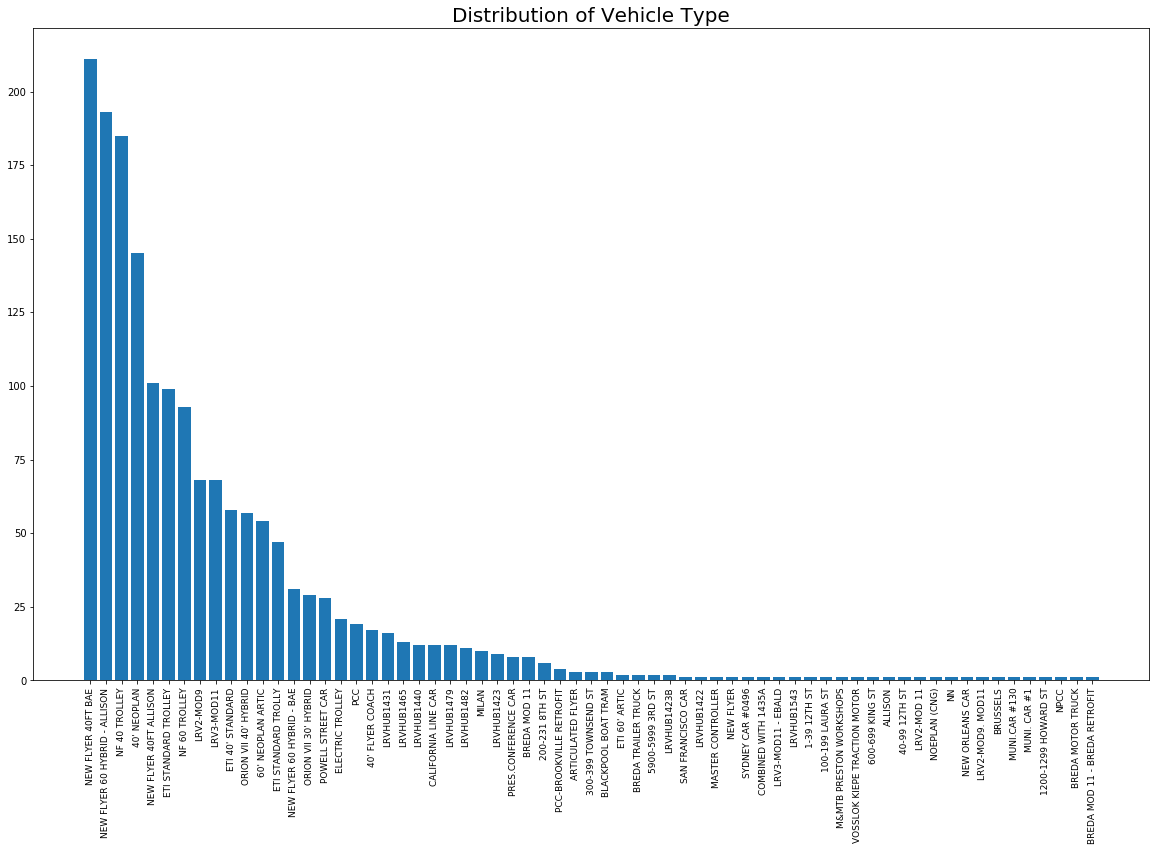

In [7]:
x = vehicle_types['EQUIP_NAME'].value_counts().index
y = vehicle_types['EQUIP_NAME'].value_counts().values

plt.figure(1, figsize=(20,12))
plt.bar(x, y)
plt.title("Distribution of Vehicle Type", fontsize=20)
plt.xticks(rotation=90, fontsize=9)
fig = plt.gcf()
fig.savefig('../../images/vehicle_types.pdf')
plt.show()

In [8]:
vehicle_types.groupby('EQUIP_NAME').head(vehicle_types.shape[0]).to_csv('../../temp_data/code_by_vehicle_name.csv', index=False)

## 2. Analysis of vehicle codes 

Observations from analyzing the vehicle code table:
1. Certain vehicle types occupy a range of numbers used as the identifying code. (i.e., 4000' classifies 40' FLYER COACH, where as 1800's correspond to MILAN)
2. One of the vehicle names is spelled 'ETI STANDARD TROLLY', where TROLLY is missing an 'E' at the end. This typo can explain why there is another vehicle type named 'ETI STANDARD TROLLEY'. We will correct the spelling error and combine the two into one vehicle type. 
3. Whenever the EQUIP_CODE jumps by a certain amount (roughly minimum of 20) it switches to identify a new vehicle type. 
4. PCC is possible short for PRES CONFERENCE CAR and not a truly different vehicle type. This is also likely due to the corresponding number id falling within the same range of 1000 - 1100. Change PCC to PRES.CONFERENCE CAR.  
5. Certain vehicle types may still be the same class of vehicles (i.e., TROLLEY, BUS, RAILCAR, etc) and therefore have comparable speeds.
6. POWELL STREET CAR and MUNI. CAR \#1 share the same EQUIP_CODE. Drop the MUNI. CAR \#1 since the range of numbers shared here (1-30) correspond to POWELL STREET CAR. 

In [8]:
# Load vehicle types
vehicle_types = pd.read_csv('../../temp_data/code_by_vehicle_name(edited).csv', usecols=[0,1])
print("Size of df: {}".format(vehicle_types.shape))
print("Number of unqiue v-types: {}".format(vehicle_types["EQUIP_NAME"].nunique()))
vehicle_types.head()

Size of df: (1688, 2)
Number of unqiue v-types: 62


,EQUIP_CODE,EQUIP_NAME
0,1,POWELL STREET CAR
1,2,POWELL STREET CAR
2,3,POWELL STREET CAR
3,4,POWELL STREET CAR
4,5,POWELL STREET CAR


In [89]:
vehicle_types.dtypes

EQUIP_CODE    object
EQUIP_NAME    object
dtype: object

In [9]:
vehicle_map = {}

for i, v in vehicle_types.values:
    vehicle_map[i] = v
    
print(len(vehicle_map))

1688


## 3. Map Vehicle type to one sample dataset

In [10]:
# Monthly speed data by region
region_data_dir = '../../temp_data/region_data/'

print('Number of region files: {}'.format(len(os.listdir(region_data_dir))))
files = os.listdir(region_data_dir)

Number of region files: 196


In [11]:
sample_df = pd.read_csv(region_data_dir + files[1])
print("Dimensions: {}".format(sample_df.shape))
print('Unique keys: {}'.format(sample_df['VEHICLE_TAG'].nunique()))
sample_df.head()

Dimensions: (160405, 9)
Unique keys: 505


,REV,REPORT_TIME,VEHICLE_TAG,LONGITUDE,LATITUDE,SPEED,geometry,index_right,geoid10
0,1513,2016-02-01 06:51:43,5403,-122.43606,37.79961,3.056,POINT (-122.43606 37.79960999999999),21,6075012800
1,1513,2016-02-01 08:59:05,5403,-122.43570,37.79811,2.500,POINT (-122.4357 37.79811),21,6075012800
2,1513,2016-02-01 09:00:35,5403,-122.43717,37.79680,1.944,POINT (-122.43717 37.7968),21,6075012800
3,1513,2016-02-01 11:18:21,5403,-122.43706,37.79635,6.111,POINT (-122.43706 37.79635),21,6075012800
4,1513,2016-02-01 13:04:39,5403,-122.43720,37.79650,4.444,POINT (-122.4372 37.7965),21,6075012800


In [12]:
sample_df['VEHICLE_NAME'] = sample_df['VEHICLE_TAG'].map(vehicle_map)
print('Unique vehicle names: {}'.format(sample_df['VEHICLE_NAME'].nunique()))

Unique vehicle names: 9


Clearly, not all vehicle tags mapped successfully. Check to see how many tags did not match to the vehicle type table

In [13]:
print("Non mapping vehicle tags: {}".format(sample_df[sample_df['VEHICLE_NAME'].isna()]['VEHICLE_TAG'].nunique()))
print(sorted(sample_df[sample_df['VEHICLE_NAME'].isna()]['VEHICLE_TAG'].unique()))

Non mapping vehicle tags: 84
['5401', '5402', '5403', '5406', '5411', '5412', '5418', '5423', '5426', '5427', '5431', '5434', '5439', '5459', '5464', '5468', '5481', '5488', '5507', '5511', '5512', '5516', '5522', '5531', '5532', '5537', '5564', '5591', '5602', '5620', '5623', '5636', '5640', '6204', '8001', '8004', '8009', '8011', '8014', '8015', '8017', '8024', '8026', '8027', '8032', '8042', '8104', '8111', '8112', '8122', '8137', '8139', '8140', '8147', '8179', '8187', '8190', '8191', '8204', '8213', '8219', '8220', '8226', '8228', '8229', '8235', '8309', '8311', '8315', '8335', '8340', '8343', '8348', '8350', '8355', '8357', '8358', '8359', '8360', '8366', 'T043', 'T280', 'T283', 'T286']


In [14]:
# Missing vehicle names
sample_df.isna().sum()

REV                 0
REPORT_TIME         0
VEHICLE_TAG         0
LONGITUDE           0
LATITUDE            0
SPEED               0
geometry            0
index_right         0
geoid10             0
VEHICLE_NAME    26494
dtype: int64

In [15]:
print("{:1.2f}% of values missing".format((26494 / sample_df.shape[0])*100))

16.52% of values missing


84 vehicle tags did not map to a vehicle name.

Further analyzing the vehicle types key, we see that vehicle id's tend to correspond to certain number ranges. It is likely that these missing numbers can be assigned a vehicle type fairly accurately since their number falls within range of a vehicle type. 

For now, we will simply keep the values that did not map to a vehicle type. Instead, with the entries that mapped to a specific vehicle type, we will analyze the distribution of their speed. 

Note: Although the patterns appear strong enough, this is still an assumption we are making with the dataset. In the future, a cleaner dataset can prevent issues such as this. 

In [17]:
def cust_hist(x, n_bins=20, **kwargs):
    bins = np.linspace(x.min(), x.max(), n_bins)
    plt.hist(x, bins, edgecolor='white', **kwargs)

<Figure size 432x288 with 0 Axes>

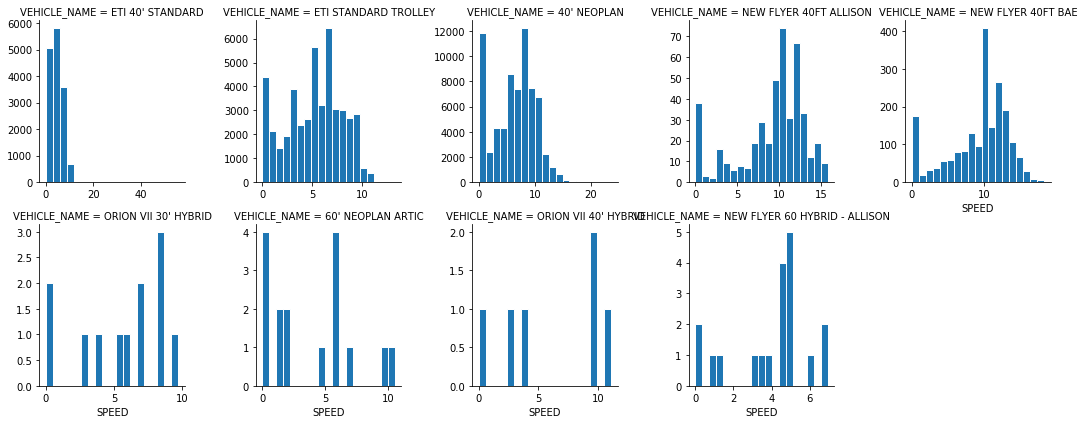

In [19]:
# 6075012800 - 1
plt.figure(2)
g = sns.FacetGrid(sample_df, col='VEHICLE_NAME', col_wrap=5, sharey=False, sharex=False)
g = g.map(cust_hist, "SPEED")
g.savefig('../../images/region6075012800_by_vehicle_type.pdf')
plt.show()

In [20]:
ETI40 = sample_df[sample_df['VEHICLE_NAME'] == "ETI 40' STANDARD"]

In [21]:
max(ETI40['SPEED'])

55.833

Some vehicle types have speeds in the 55 m/s. 
55m/s translates to around 120+ mph. It is very unlikely for a public transportation vehicle to be traveling at these speeds, thus we can consider this an outlier/error with the speed recording system. 

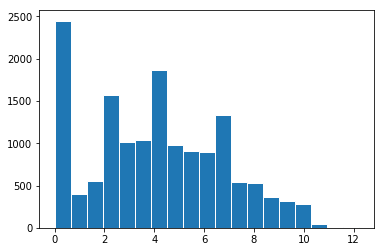

In [24]:
cust_hist(ETI40[ETI40['SPEED'] <= 35]['SPEED'], n_bins = 20)

There seems to be a high number of 0s. Since we do not know how to interpret these values, we cannot remove these values as they could be meaningful (i.e, could indicate traffic stops when all vehicles stop)

## 4. Observe Distribution of Vehicle Speed by Vehicle type for all monthly data (feb 2016)

In [25]:
main_df = pd.read_csv(region_data_dir + files[0], usecols=['SPEED', 'VEHICLE_TAG'], dtype={'SPEED': np.float,
                                                                                     'VEHICLE_TAG': str})
size = []
size.append(main_df.shape[0])

for i in files[1:]:
    sample_df = pd.read_csv(region_data_dir + i, usecols=['SPEED', 'VEHICLE_TAG'], dtype={'SPEED': np.float,
                                                                                    'VEHICLE_TAG': str})
    size.append(sample_df.shape[0])
    main_df = pd.concat([main_df, sample_df], axis=0, ignore_index=True)
    
print("Total number of rows combined: {}".format(sum(size)))

Total number of rows combined: 33350866


In [26]:
main_df.columns = ['KEY', 'SPEED']
print(main_df.dtypes)
print("Dimensions: {}".format(main_df.shape))
print('Unique keys: {}'.format(main_df['KEY'].nunique()))
main_df.head()

KEY       object
SPEED    float64
dtype: object
Dimensions: (33350866, 2)
Unique keys: 1261


,KEY,SPEED
0,5486,0.000
1,5486,0.000
2,5486,3.056
3,5494,10.556
4,5494,10.278


In [27]:
# Check sparsity of data
main_df.isna().sum()

KEY      0
SPEED    0
dtype: int64

In [28]:
# Map vehicle type to key
main_df['VEHICLE_NAME'] = main_df['KEY'].map(vehicle_map)
print("Dimensions: {}".format(main_df.shape))
print("Unique vehicle names: {}".format(main_df['VEHICLE_NAME'].nunique()))
main_df.head()

Dimensions: (33350866, 3)
Unique vehicle names: 27


,KEY,SPEED,VEHICLE_NAME
0,5486,0.000,ETI STANDARD TROLLEY
1,5486,0.000,ETI STANDARD TROLLEY
2,5486,3.056,ETI STANDARD TROLLEY
3,5494,10.556,ETI STANDARD TROLLEY
4,5494,10.278,ETI STANDARD TROLLEY


In [29]:
main_df.isna().sum()

KEY                   0
SPEED                 0
VEHICLE_NAME    4938340
dtype: int64

In [30]:
print("{:1.2f}% of values missing".format((main_df.isna().sum().values[-1] / main_df.shape[0])*100))

14.81% of values missing


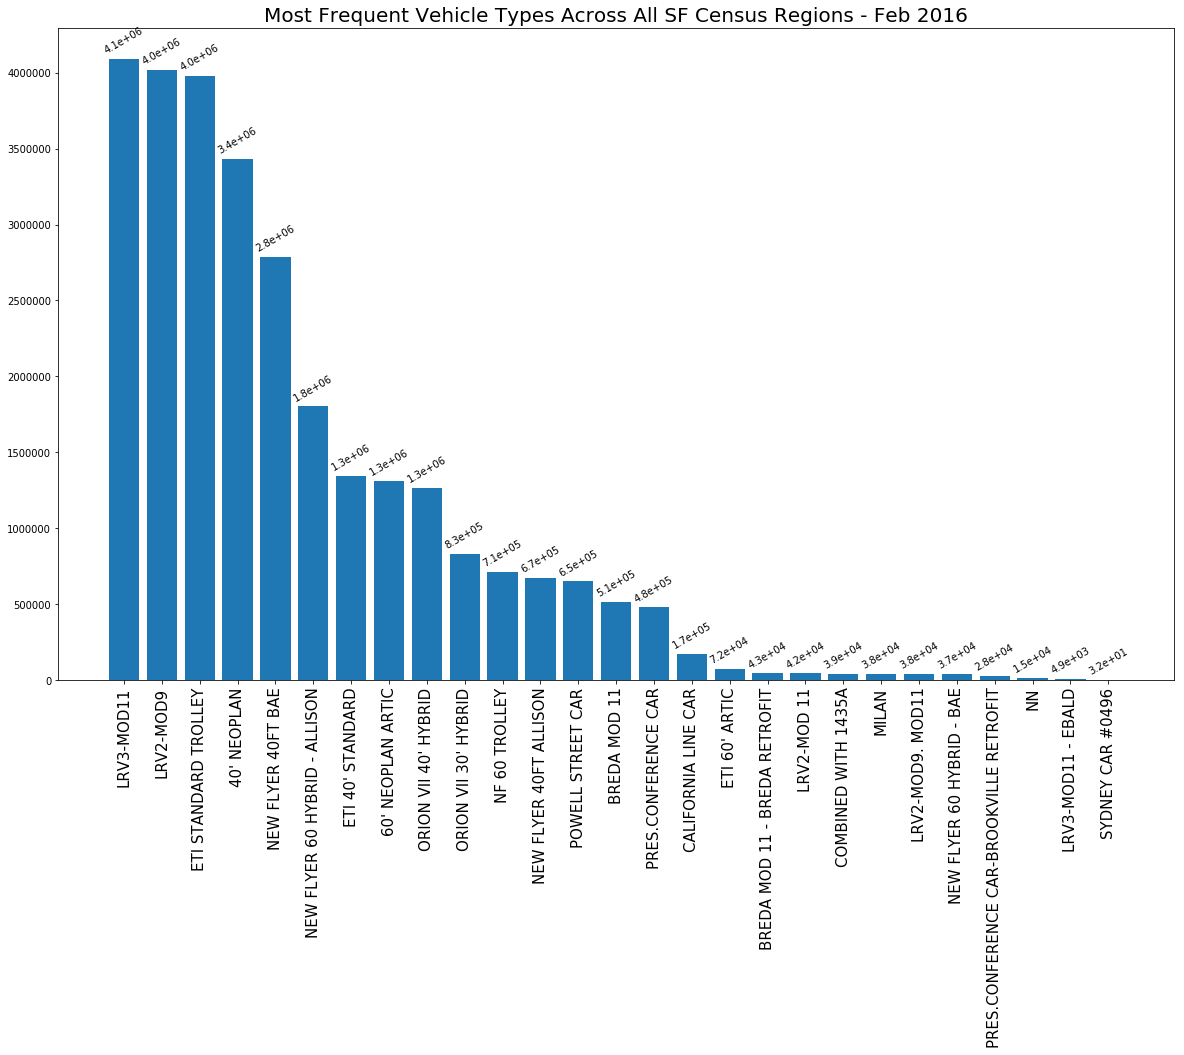

In [31]:
# See the number of times a vehicle appears
x = main_df['VEHICLE_NAME'].value_counts().index
y = main_df['VEHICLE_NAME'].value_counts().values
plt.figure(3, figsize=(20,12))
fig = plt.bar(x, y)
plt.title("Most Frequent Vehicle Types Across All SF Census Regions - Feb 2016", fontsize=20)
plt.xticks(rotation=90, fontsize=15)
for rects in fig.patches:
    # y-axis value
    height = rects.get_height()
    plt.text(rects.get_x()+rects.get_width()/2.0,
            height+170000,
            '{:.1e}'.format(height),
            ha='center',
            rotation=30,
            fontsize=10)

fig = plt.gcf()
fig.savefig('../../images/frequency_of_vehicle_types_feb_2016.pdf')
plt.show()

In [32]:
print("Non mapping vehicle tags: {}".format(main_df[main_df['VEHICLE_NAME'].isna()]['KEY'].nunique()))
print(sorted(main_df[main_df['VEHICLE_NAME'].isna()]['KEY'].unique()))

Non mapping vehicle tags: 369
['401', '402', '403', '404', '405', '406', '407', '408', '409', '410', '411', '412', '413', '414', '415', '416', '417', '418', '419', '420', '421', '422', '423', '424', '425', '426', '427', '428', '429', '430', '431', '432', '433', '434', '435', '436', '437', '438', '439', '440', '441', '442', '443', '444', '445', '446', '447', '448', '449', '450', '451', '452', '453', '454', '455', '456', '457', '458', '459', '460', '461', '462', '463', '464', '465', '466', '467', '468', '469', '470', '471', '472', '473', '474', '475', '476', '477', '478', '479', '480', '481', '482', '483', '484', '485', '486', '487', '488', '489', '490', '491', '492', '493', '494', '495', '497', '498', '499', '500', '5401', '5402', '5403', '5406', '5411', '5412', '5418', '5423', '5426', '5427', '5431', '5434', '5439', '5459', '5464', '5468', '5481', '5488', '5507', '5511', '5512', '5516', '5522', '5531', '5532', '5537', '5564', '5591', '5602', '5620', '5623', '5632', '5636', '5640', '620

<Figure size 432x288 with 0 Axes>

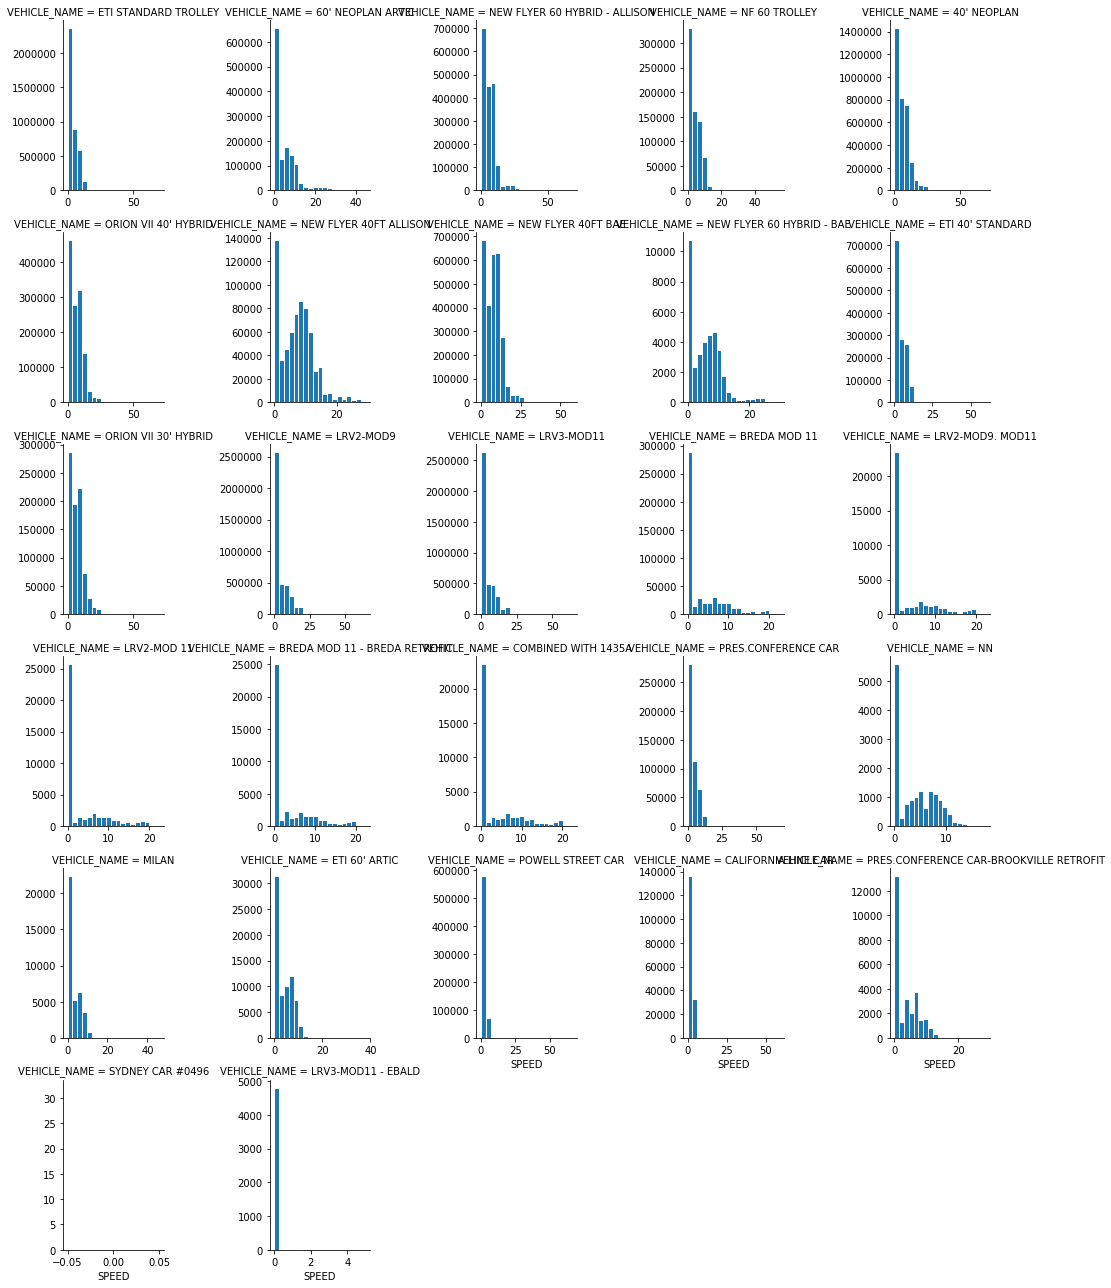

In [34]:
plt.figure(4)
g = sns.FacetGrid(main_df, col='VEHICLE_NAME', col_wrap=5, sharey=False, sharex=False)
g = g.map(cust_hist, "SPEED")
g.savefig('../../images/speed_by_vehicle_type_feb_2016.pdf')
plt.show()

## 5. Filter data

In [44]:
# Calculate the mean speed and standard deviation
mean = np.mean(main_df['SPEED'])
std = np.std(main_df['SPEED'])
maximum = max(main_df['SPEED'])
print("Mean: {:.2f}".format(mean))
print("Standard deviation: {:.2f}".format(std))
print("Maximum speed: {}m/s".format(maximum))

Mean: 4.45
Standard deviation: 5.05
Maximum speed: 69.444m/s


Detect extreme outliers - defined as 3 times the IQR below the first quantile or above the third quantile.   
$x < Q1 - 3 \times IQR$  
$x > Q3 + 3 \times IQR$

In [47]:
q1, q2, q3 = np.percentile(main_df['SPEED'], [25, 50, 75])
print("Q1: {}, Q2:{}, Q3: {}".format(q1, q2, q3))

Q1: 0.0, Q2:3.333, Q3: 7.5


In [51]:
iqr = q3 - q1
ex_outlier = q3 + 3 * iqr
print("Extreme outliers: x > {}".format(ex_outlier))

Extreme outliers: x > 30.0


This translates to around 67.10 mph

In [52]:
filtered_df = main_df[main_df['SPEED'] <= ex_outlier].reset_index(drop=True)
print("Dimensions: {}".format(filtered_df.shape))
print("Rows removed: {} or {:.5f}%".format(main_df.shape[0] - filtered_df.shape[0], ((main_df.shape[0] - filtered_df.shape[0])/main_df.shape[0])*100))

Dimensions: (33348449, 3)
Rows removed: 2417 or 0.00725%


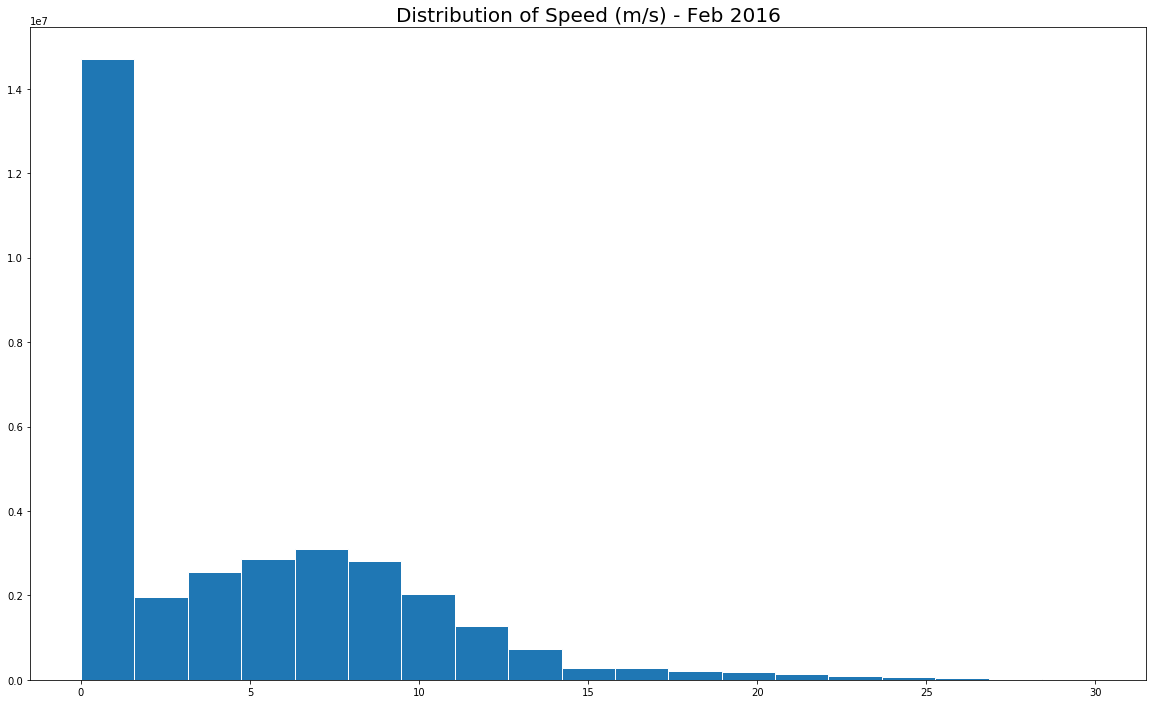

In [53]:
plt.figure(5, figsize=(20,12))
cust_hist(filtered_df['SPEED'], n_bins=20)
plt.title("Distribution of Speed (m/s) - Feb 2016", fontsize=20)
fig = plt.gcf()
fig.savefig("../../images/distribution_of_speed_feb_2016")
plt.show()

<Figure size 432x288 with 0 Axes>

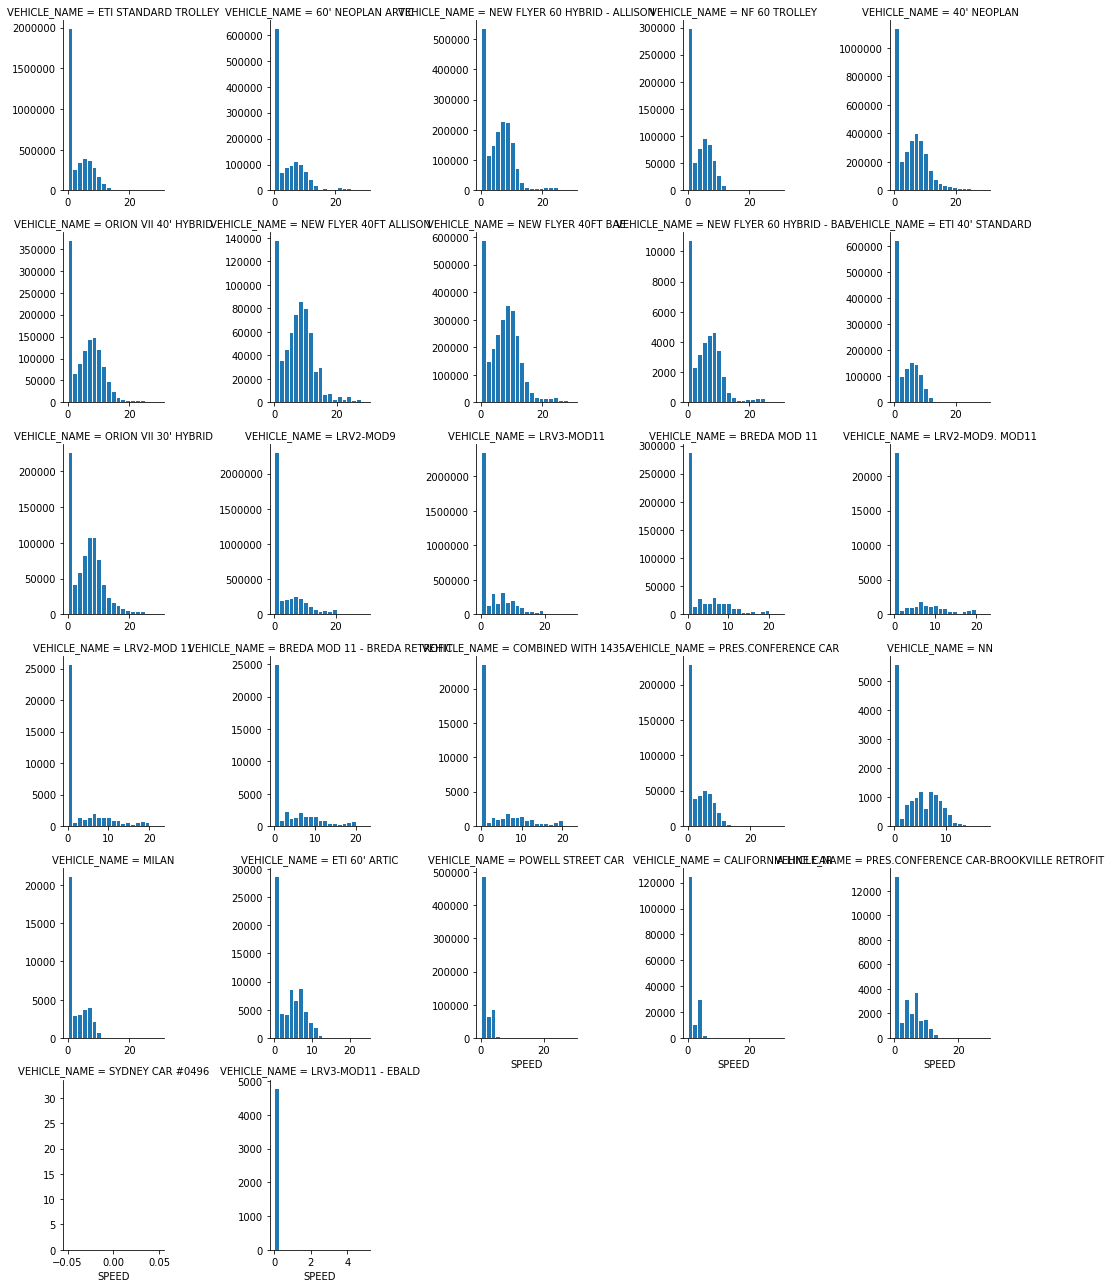

In [54]:
plt.figure(6)
g = sns.FacetGrid(filtered_df, col='VEHICLE_NAME', col_wrap=5, sharey=False, sharex=False)
g = g.map(cust_hist, "SPEED")
g.savefig('../../images/speed_by_vehicle_type_feb_2016(filtered).pdf')
plt.show()

Find Vehicles with questionable speeds (mostly in 0 range).
If they are mostly 0 speed consider removing them from the data as it will severely skew the average speed of each region.

Generate higher resolution histograms for the following vehicle types:
1. POWELL STREET CAR
2. CALIFORNIA LINE CAR
3. SYDNEY CAR #0496
4. LRV3-MOD11 - EBALD

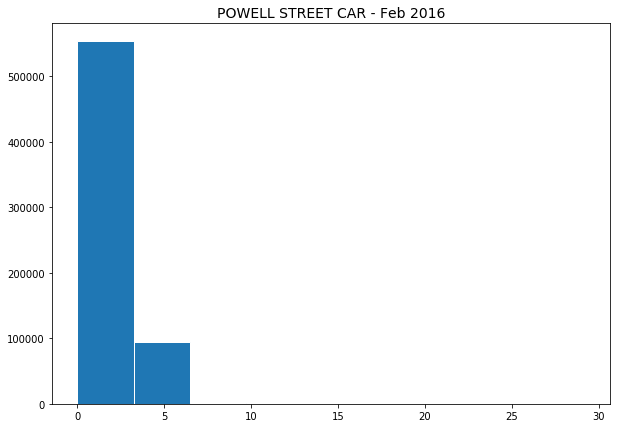

In [59]:
plt.figure(7, figsize=(10,7))
cust_hist(filtered_df[filtered_df["VEHICLE_NAME"] == "POWELL STREET CAR"]["SPEED"], n_bins=10)
plt.title("POWELL STREET CAR - Feb 2016", fontsize=14)
plt.show()

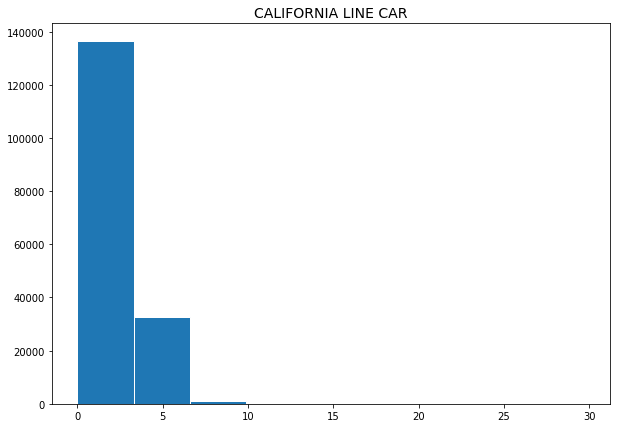

In [81]:
plt.figure(8, figsize=(10,7))
cust_hist(filtered_df[filtered_df["VEHICLE_NAME"] == "CALIFORNIA LINE CAR"]["SPEED"], n_bins=10)
plt.title("CALIFORNIA LINE CAR", fontsize=14)
plt.show()

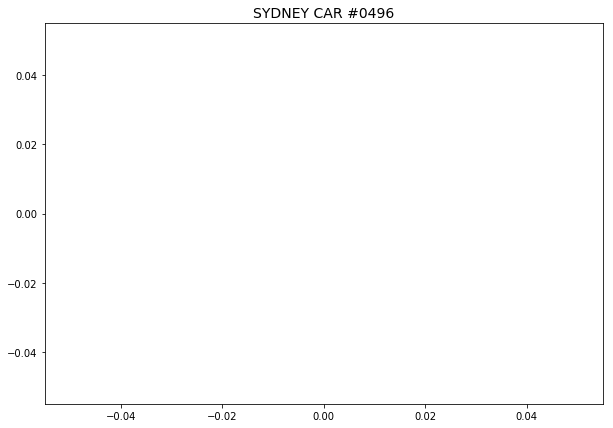

In [82]:
plt.figure(9, figsize=(10,7))
cust_hist(filtered_df[filtered_df["VEHICLE_NAME"] == "SYDNEY CAR #0496"]["SPEED"], n_bins=1)
plt.title("SYDNEY CAR #0496", fontsize=14)
plt.show()

In [85]:
# Check speed values
filtered_df[filtered_df["VEHICLE_NAME"] == "SYDNEY CAR #0496"]["SPEED"].value_counts()

0.0    32
Name: SPEED, dtype: int64

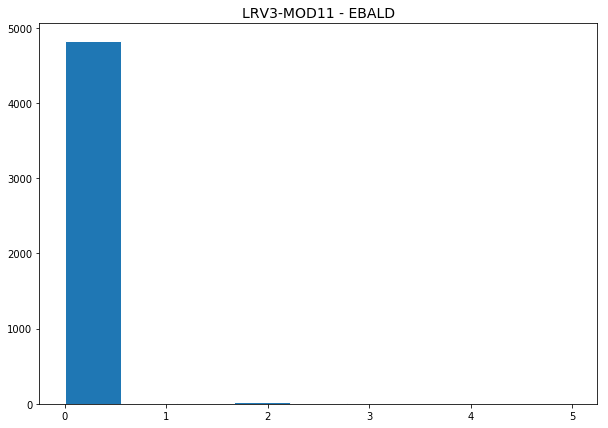

In [71]:
plt.figure(10, figsize=(10,7))
cust_hist(filtered_df[filtered_df["VEHICLE_NAME"] == "LRV3-MOD11 - EBALD"]["SPEED"], n_bins=10)
plt.title("LRV3-MOD11 - EBALD", fontsize=14)
plt.show()

The California Line and Powell street car are both cable cars. Unlike buses and cars, cable cars operate on designated tracks and have relatively low speeds. We can expect these vehicle types to appear only in certain census regions.

Additionally, over the month of Feb, SYDNEY CAR #0496 only had speed readings of 0m/s, so we will remove this vehicle type. 

Additionally, we will remove LRV3-MOD11-EBALD as majority of its speed is well below 1 m/s. 

## 6. Filter all region speed datasets

In [91]:
size = []
excluded_v_types = ["SYDNEY CAR #0496", "LRV3-MOD11 - EBALD"]

for i in files:
    data_table = pd.read_csv(region_data_dir + i, dtype={"VEHICLE_TAG": str})
    size.append(data_table.shape[0])
    data_table["VEHICLE_NAME"] = data_table["VEHICLE_TAG"].map(vehicle_map)
    
    # Filter out extreme outliers
    data_table_f = data_table[data_table['SPEED'] <= ex_outlier].reset_index(drop=True)
    
    # Filter out excluded vehicle types
    data_table_f = data_table_f[~data_table_f["VEHICLE_NAME"].isin(excluded_v_types)].reset_index(drop=True)
    
    data_table_f.to_csv("../../temp_data/region_data_filtered/filtered_{}".format(i), index=False)
    difference = data_table.shape[0] - data_table_f.shape[0]
    print("{} - finished filtering - {} original # of rows - {} row(s) removed - {:.5f}% reduction".format(i, data_table.shape[0], difference, (difference / data_table.shape[0])*100))

print('****DONE. Total number of rows read: {}****'.format(sum(size)))

time_series_region_6075047801.csv - finished filtering - 98216 original # of rows - 1 row(s) removed - 0.00102% reduction
time_series_region_6075012800.csv - finished filtering - 160405 original # of rows - 1 row(s) removed - 0.00062% reduction
time_series_region_6075021400.csv - finished filtering - 47769 original # of rows - 1 row(s) removed - 0.00209% reduction
time_series_region_6075025100.csv - finished filtering - 129054 original # of rows - 15 row(s) removed - 0.01162% reduction
time_series_region_6075042602.csv - finished filtering - 94047 original # of rows - 0 row(s) removed - 0.00000% reduction
time_series_region_6075023001.csv - finished filtering - 105617 original # of rows - 54 row(s) removed - 0.05113% reduction
time_series_region_6075030900.csv - finished filtering - 267029 original # of rows - 4 row(s) removed - 0.00150% reduction
time_series_region_6075013101.csv - finished filtering - 51107 original # of rows - 1 row(s) removed - 0.00196% reduction
time_series_region